# Comparison of Optimization Problems to SEKO Assignment 

The assignment of the seminars with respect to the key objectives is formulated by means of integer linear programming (ILP). The first ILP maximizes the utilization, i.e., the number of assigned places to students, and is referred to as 'MU'. The resulting maximum utilization $U^*$ is then used as constrained in the other ILP problems. The ILP 'MU+1' provides an assignment which maximizes the ratio of students who are assigned at least one seminar. Thereby, the maximum utilization which can be achieved is added as a constraint. The third ILP 'MU+F' aims at maximizing fairness while considering the maximum utilization as constraint. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import moduleSEKO as seko

# read input file
x, userid, seminar_capacity, seminarNames, list_seminar_types, dict_semTypes  = seko.readExcelFile(file='input.xlsx' )

# get number of requests per seminar and per seminar type
Ri = np.zeros((len(userid), len(dict_semTypes)), dtype='int') # number of seminar requests per student per seminar type
for k,sem in enumerate(dict_semTypes):
    Ri[:,k] = x[:,dict_semTypes[sem]].sum(axis=1)    
reqSemTypes = np.sign(Ri) 
numReqSemTypes = reqSemTypes.sum(axis=1) # number of requests per seminar type
maxNumReqSemTypes = numReqSemTypes.max() # maximum number of requests per seminar type (for plotting)   

#%% optimization problems are executed
# the assignments are stored in the correspond y_mip variables
y_util, tmp = seko.mip_MaxSeminarUtilization(x, seminar_capacity, dict_semTypes, seed=42)  # optimization problem MU
y_alos, tmp = seko.mip_AtLeastOneSeminar(x, seminar_capacity, dict_semTypes, seed=42, capacity=y_util.sum())  # optimization problem MU+1
y_fair, tmp = seko.mip_MaxFairness(x, seminar_capacity, dict_semTypes, capacity=y_util.sum(), seed=42)  # optimization problem MU+F   
   

#%% read output file from SEKO assignment
df = pd.read_excel('output.xlsx', sheet_name='Assignment') 
y = df.values[:,1:] # assignment matrix of the SEKO strategy

y_fifo = seko.fifoAssignment(x, seminar_capacity, dict_semTypes, list_seminar_types,maxSeminarsAssignedPerParticipant=999)

#%% print the performance of the MIPs and SEKO
for yi, label in zip([y_util, y_alos, y_fair, y_fifo, y],['Optimization Problem: Maximum Utilization Problem (MU)',
                                                  'Optimization Problem: Assigning At Least One Seminar Problem (MU+1)', 
                                                  'Optimization Problem: Maximizing Fairness and Utilization Problem (MU+F)',                                                  
                                                  'FIFO Assignment Strategy',        
                                                  'SEKO Assignment Strategy']):
    print(f'{label}')
    print(f'  utilization U={seko.capacityUtilization(yi, seminar_capacity):g}')
    print(f'  ALOS ratio  L={seko.ratioUserWithAtLeastSeminar(yi):g}')
    print(f'  fairness    F={seko.fairnessStdAssSems(yi,dict_semTypes):g}\n')

Optimization Problem: Maximum Utilization Problem (MU)
  utilization U=0.842857
  ALOS ratio  L=0.978723
  fairness    F=0.657072

Optimization Problem: Assigning At Least One Seminar Problem (MU+1)
  utilization U=0.842857
  ALOS ratio  L=1
  fairness    F=0.611803

Optimization Problem: Maximizing Fairness and Utilization Problem (MU+F)
  utilization U=0.842857
  ALOS ratio  L=1
  fairness    F=0.807071

FIFO Assignment Strategy
  utilization U=0.842857
  ALOS ratio  L=0.893617
  fairness    F=0.560398

SEKO Assignment Strategy
  utilization U=0.842857
  ALOS ratio  L=1
  fairness    F=0.743894



# Visualize the Assignment

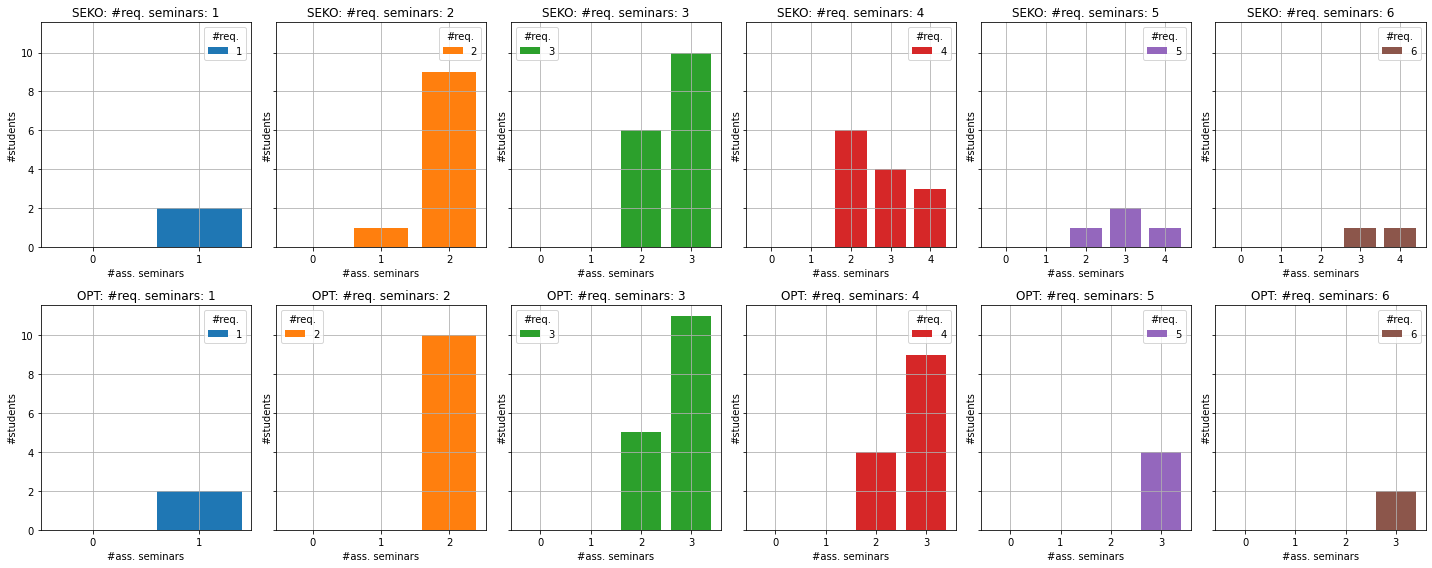

In [5]:
def plotAssignment(yy, axs, subplot=0, label='SEKO'):    
    Ai = np.zeros((len(userid), len(dict_semTypes)), dtype='int')    
    for k,sem in enumerate(dict_semTypes):        
        Ai[:,k] = yy[:,dict_semTypes[sem]].sum(axis=1)    
            
    for i in (np.unique(numReqSemTypes)):
        plt.sca(axs[subplot,i-1])
        w = numReqSemTypes==i
        c = np.bincount(Ai[w,:].sum(axis=1))
        plt.bar(range(len(c)),c,label=i, color=plt.cm.tab10(i-1))
        plt.title(f'{label}: #req. seminars: {i}') 
        plt.legend(title='#req.') 
        plt.xlabel('#ass. seminars')
        plt.xticks(range(len(c)))
        plt.ylabel('#students')   
        plt.grid(which='major')
#%%
fig, axs = plt.subplots(2,maxNumReqSemTypes,sharey=True, num=1, clear=True,  figsize=(20,8))
plotAssignment(y,axs,0,label='SEKO')
plotAssignment(y_fair,axs,1,label='OPT')
plt.tight_layout();

# Direct Comparison

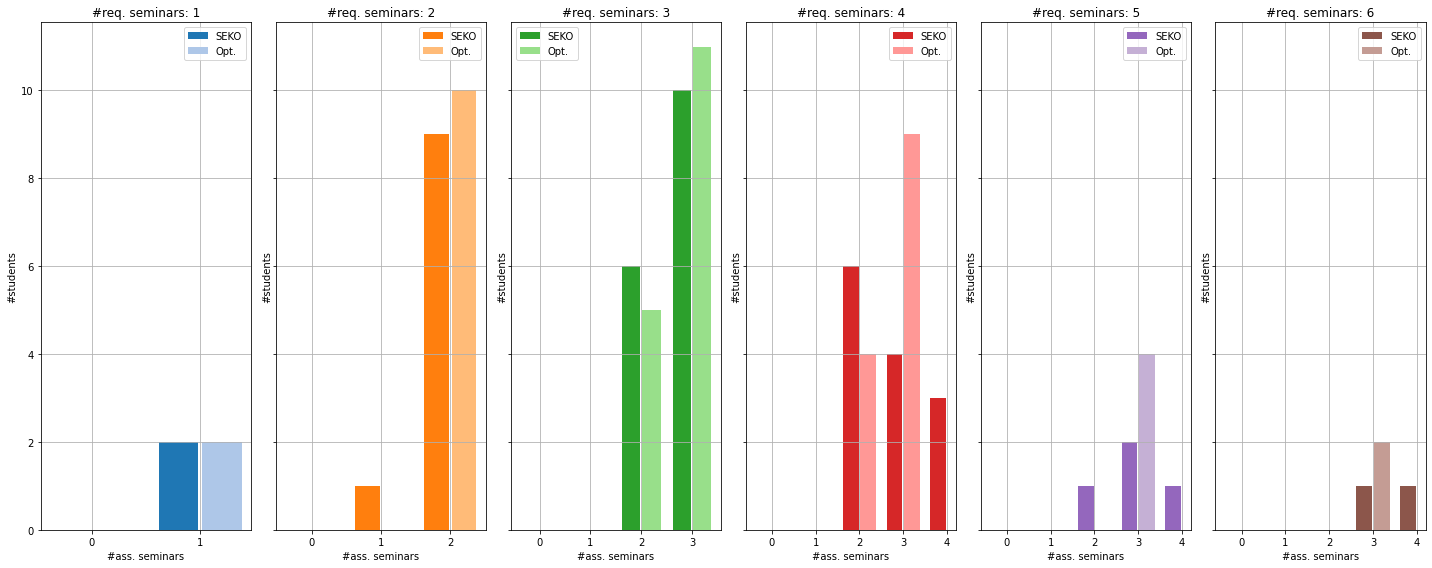

In [6]:
def plotAllAssignment(y1,y2):
    fig, axs = plt.subplots(1,maxNumReqSemTypes,sharey=True, num=10, clear=True,  figsize=(20,8))    
    Ai1 = np.zeros((len(userid), len(dict_semTypes)), dtype='int')    
    Ai2 = np.zeros((len(userid), len(dict_semTypes)), dtype='int')
    
    for k,sem in enumerate(dict_semTypes):        
        Ai1[:,k] = y1[:,dict_semTypes[sem]].sum(axis=1)
        Ai2[:,k] = y2[:,dict_semTypes[sem]].sum(axis=1)
        
    width=0.4
    
    for color,i in enumerate(np.unique(numReqSemTypes)):
        plt.sca(axs[i-1])
        #plt.subplot(1,5,i
        #seko.cdfplot(Ai.sum(axis=1)/reqSemTypes.sum(axis=1))
        w = numReqSemTypes==i
        c1 = np.bincount(Ai1[w,:].sum(axis=1))
        c2 = np.bincount(Ai2[w,:].sum(axis=1))
        #print(np.arange(len(c1))-width/2)
        plt.bar(np.arange(len(c1))-width/2,c1, color=plt.cm.tab20(2*color), width=width*0.9, label='SEKO')
        plt.bar(np.arange(len(c2))+width/2,c2, color=plt.cm.tab20(2*color+1), width=width*0.9, label='Opt.')
        #seko.cdfplot(Ai[w,:].sum(axis=1)/numReqSemTypes[w], label=i)
        plt.title(f'#req. seminars: {i}') 
        plt.legend() 
        plt.xlabel('#ass. seminars')
        plt.xticks(range(max(len(c1),len(c2))))
        plt.ylabel('#students')   
        plt.grid(which='major')        
        
plotAllAssignment(y,y_fair)
plt.tight_layout();